In [1]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import math


In [2]:
# for plot
%matplotlib inline
import matplotlib.pyplot as plt
from plot_func import my_anima_3d_h 
from IPython.display import HTML

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Shallow Water Equation - 1D Linear

Continuity Equation
$$\frac{\partial h}{\partial t} + H\frac{\partial u}{\partial x}+ H\frac{\partial v}{\partial y}=0 $$
Momentum Equation
$$\frac{\partial u}{\partial t} = - g\frac{\partial h}{\partial x} $$
$$\frac{\partial v}{\partial t} = - g\frac{\partial h}{\partial y} $$


In [4]:

# define ANN structure
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_Tanh_stack = nn.Sequential(
            nn.Linear( 3, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20,  3),
        )

    def forward(self, x):
        logits = self.linear_Tanh_stack(x)
        return logits
# define PINN structure
class PINN():
    def __init__(self,t_axis, x_axis, y_axis, IC_func, g, H):
        # accounting for scale change by normalization
        self.t_min_max = [t_axis.min(),t_axis.max()]
        self.x_min_max = [x_axis.min(),x_axis.max()]
        self.y_min_max = [y_axis.min(),y_axis.max()]
        self.t_grad_scale = torch.tensor(1/(t_axis.max()-t_axis.min())).to(device) 
        self.x_grad_scale = torch.tensor(1/(x_axis.max()-x_axis.min())).to(device) 
        self.y_grad_scale = torch.tensor(1/(y_axis.max()-y_axis.min())).to(device) 
        
        #parameters
        self.g = torch.tensor(g).to(device)
        self.H = torch.tensor(H).to(device)
        
        # initialization grids from regular x and t
        # Collocation points 
        t_axis_nor,x_axis_nor,y_axis_nor = self.coordination_normalization(t_axis,x_axis,y_axis)
        self.txy_col = self.axis_txy_to_ij(t_axis_nor[:], x_axis_nor, y_axis_nor) 
        # BC points
        self.BC_xl  = self.axis_txy_to_ij(t_axis_nor, x_axis_nor[ 0], y_axis_nor)
        self.BC_xr  = self.axis_txy_to_ij(t_axis_nor, x_axis_nor[-1], y_axis_nor) 
        self.BC_yl  = self.axis_txy_to_ij(t_axis_nor, y_axis_nor[ 0], y_axis_nor)
        self.BC_yr  = self.axis_txy_to_ij(t_axis_nor, y_axis_nor[-1], y_axis_nor)  
        # IC points 
        self.IC_txy  = self.axis_txy_to_ij(t_axis_nor[0], x_axis_nor, y_axis_nor)
        x_axis_ij, y_axis_ij = np.meshgrid(x_axis, y_axis, indexing='ij') 
        
        IC_expected = IC_func(x_axis_ij.flatten(), y_axis_ij.flatten()) # x before normalization
        self.IC_expected = torch.tensor(IC_expected).to(device) 
        # Collocation points with require gradient = True
        self.txy_col.requires_grad  = True
        self.BC_xl.requires_grad = True
        self.BC_xr.requires_grad = True
        self.BC_yl.requires_grad = True
        self.BC_yr.requires_grad = True
     # initial ANN
        self.NN_model = NeuralNetwork().to(device)
#         self.optimizer = torch.optim.SGD(self.NN_model.parameters(),lr=0.01)
        self.optimizer = torch.optim.Adam(self.NN_model.parameters(), lr=0.005, betas=(0.9, 0.999))
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)
#         self.optimizer_warmup = torch.optim.SGD(self.NN_model.parameters(),lr=0.01)
        self.optimizer_warmup = torch.optim.Adam(self.NN_model.parameters(), lr=0.01, betas=(0.9, 0.999))
    def axis_txy_to_ij(self, t_axis, x_axis, y_axis):
        t_col,x_col,y_col = np.meshgrid(t_axis, x_axis, y_axis, indexing='ij') 
        # time & space mesh in rows
        txy_col = np.concatenate((t_col.reshape(-1,1),
                                  x_col.reshape(-1,1), 
                                  y_col.reshape(-1,1)), 
                                  axis=1,dtype='float32')
        return torch.tensor(txy_col).to(device) 
    def axis_xy_to_ij(self, x_axis, y_axis):
        x_col,y_col = np.meshgrid(x_axis, y_axis, indexing='ij') 
        # time & space mesh in rows
        xy_col = np.concatenate((x_col.reshape(-1,1), 
                                 y_col.reshape(-1,1)), 
                                  axis=1,dtype='float32')
        return torch.tensor(xy_col).to(device) 

    def coordination_normalization(self,t_axis,x_axis,y_axis):
        t_axis_nor = (t_axis-self.t_min_max[0])*self.t_grad_scale.item()
        x_axis_nor = (x_axis-self.x_min_max[0])*self.x_grad_scale.item()
        y_axis_nor = (y_axis-self.y_min_max[0])*self.y_grad_scale.item()
        return t_axis_nor,x_axis_nor,y_axis_nor 

    # define loss function
    def output_gradient(self,output,collocation_point):
        output_tx = torch.autograd.grad(output,collocation_point,grad_outputs=torch.ones_like(output), 
                                        create_graph=True)[0]
        return output_tx

    def loss_PDE(self,txy_col):
        output = self.NN_model(txy_col)
        h = output[:,0] 
        u = output[:,1] 
        v = output[:,2] 
        h_tx = self.output_gradient(h,txy_col)
        u_tx = self.output_gradient(u,txy_col)
        v_tx = self.output_gradient(v,txy_col)
        h_t = h_tx[:,0]
        h_x = h_tx[:,1]
        h_y = h_tx[:,2]
        u_t = u_tx[:,0]
        u_x = u_tx[:,1]
        u_y = u_tx[:,2]
        v_t = v_tx[:,0]
        v_x = v_tx[:,1]
        v_y = v_tx[:,2]
        # PDE1 : Continuity equation
        # \frac{\partial h}{\partial t} + H\frac{\partial u}{\partial x}+ H\frac{\partial v}{\partial y}=0
        LHS1 = h_t   
        RHS1 = - self.H * u_x *(self.x_grad_scale/self.t_grad_scale)\
               - self.H * v_y *(self.y_grad_scale/self.t_grad_scale)
        loss_f1 = torch.nn.MSELoss()(LHS1, RHS1)
        # PDE2: x Momentum Equation
        # \frac{\partial u}{\partial t}= - g\frac{\partial h}{\partial x}$$
        LHS2 = u_t * ( self.t_grad_scale/self.x_grad_scale) 
        RHS2 = - self.g * h_x
        loss_f2 = torch.nn.MSELoss()(LHS2, RHS2)
        # PDE2: y Momentum Equation
        # \frac{\partial v}{\partial t}= - g\frac{\partial h}{\partial y}$$
        LHS3 = v_t * ( self.t_grad_scale/self.y_grad_scale) 
        RHS3 = - self.g * h_y 
        loss_f3 = torch.nn.MSELoss()(LHS3, RHS3)
        return loss_f1, loss_f2, loss_f3

    def loss_BC(self):
        # setup periodic B.C. via loss function
        # (mixed type with derivative periodic need to test)
        # 1st type B.C. via loss function
        # periodic values, for t=?, output(x=-1) = output(x=1)
        output_bc_xl = self.NN_model(self.BC_xl)
        output_bc_xr = self.NN_model(self.BC_xr)
        loss         = torch.nn.MSELoss()(output_bc_xl, output_bc_xr)
        output_bc_yl = self.NN_model(self.BC_yl)
        output_bc_yr = self.NN_model(self.BC_yr)
        loss        += torch.nn.MSELoss()(output_bc_yl, output_bc_yr)
#         # 2nd B.C. derivative via loss function # need more research
#         # periodic derivative, for t=?, output_xt(x=-1) = output_xt(x=1)
#         output_bc_l_xt = self.output_gradient(self.BC_tx_l)
#         output_bc_r_xt = self.output_gradient(self.BC_tx_r)
#         loss       += torch.nn.MSELoss()(output_bc_l_xt, output_bc_r_xt)
        return loss

    def loss_IC(self):
        # periodic values, for all x, y, output(t=0) = IC_expected
        output = self.NN_model(self.IC_txy)
#         print(output.shape)
#         print(self.IC_expected.shape)
        loss = torch.nn.MSELoss()(output, self.IC_expected)
        return loss
    
    def col_poi_batch_index_sta_end(self,col_poi,col_poi_batch_size):
        n_batch = math.ceil(col_poi.shape[0]/col_poi_batch_size)
        col_poi_batchs = []
        sta=0
        for i in range(n_batch-1):
            end = sta + col_poi_batch_size
            col_poi_batchs.append(col_poi[sta:end,:])
            sta = end
        col_poi_batchs.append(col_poi[sta:col_poi.shape[0],:])
        return col_poi_batchs
    
    def train_IC_warmup(self,optimizer=None):
        if optimizer is None:
            optimizer = self.optimizer_warmup
       
        loss = self.loss_IC()  
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
            
    def train(self,col_poi_batch_size=None,optimizer=None):
        if optimizer is None:
            optimizer = self.optimizer
        if col_poi_batch_size is None:
            col_poi_batch_size=self.txy_col.shape[0]
        # create training dataset (index) for collocation points
        # 1st method: loop thourgh all points in batch and in order
        col_poi_batchs = self.col_poi_batch_index_sta_end(self.txy_col,col_poi_batch_size)
#         # 2nd method: loop thourgh all points randomly in batch
        
        for tx_col_batch in col_poi_batchs:
#             Compute loss: function loss + BC/IC loss
            lossf1,lossf2,lossf3 = self.loss_PDE(tx_col_batch) 
            lossBC = self.loss_BC()
            lossIC = self.loss_IC()  
            loss = lossf1 + lossf2 + lossf3 + lossBC + 5*lossIC # large on IC
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
    def predict(self,tx_col=None):
        if tx_col is None:
#             tx_col = torch.cat((self.IC_tx,self.tx_col),dim=0)
            tx_col = self.txy_col
        with torch.no_grad():
            output = self.NN_model(tx_col)
        return output
    def current_loss(self):
        # Compute loss: function loss + BC/IC loss
        lossf1,lossf2,lossf3 = 0,0,0
        n_batch = 50
        txy_col_n = self.txy_col.shape[0]
        batch_num = txy_col_n//n_batch
        for i in range(n_batch+1): # reduce memory usage
            sta_ind = batch_num*i
            if sta_ind >= txy_col_n: break
            end_ind = min(txy_col_n,batch_num*(i+1))
            lossf1_b,lossf2_b,lossf3_b = self.loss_PDE(self.txy_col[sta_ind:end_ind,:]) 
            lossf1+=lossf1_b
            lossf2+=lossf2_b
            lossf3+=lossf3_b
        lossBC = self.loss_BC()
        lossIC = self.loss_IC()  
        return [lossf1.item(),lossf2.item(),lossf3.item(),lossBC.item(),lossIC.item()]

In [5]:
# %%time
# set regular grid
t_end  = 1
t_axis = np.arange(0,t_end,0.01,dtype='float32')    # time
x_axis = np.arange(-1,1+1e-3,0.02,dtype='float32')   # space
y_axis = np.arange(-1,1+1e-3,0.02,dtype='float32')   # space

#define IC
def IC_func(x, y):
    r=x**2+y**2
    IC_h = np.where(r<0.09,1,0)
    IC_u = np.zeros_like(x)
    IC_v = np.zeros_like(x)
    return np.concatenate([IC_h[:,None], IC_u[:,None],IC_v[:,None]],axis=1).astype('float32')
#Create PDF solver
adv_2d_solver = PINN(t_axis=t_axis, x_axis=x_axis, y_axis=y_axis,IC_func=IC_func, g=1, H=1)

In [6]:
def print_loss(i,loss_tmp):
    if i is not None:
        print(f'Epoch {i:6d} ', end='')
    print(f'| fn loss1: {loss_tmp[0]:8.2e} '
         +f'| fn loss2: {loss_tmp[1]:8.2e} '
         +f'| fn loss3: {loss_tmp[2]:8.2e} '
         +f'| BC loss: {loss_tmp[3]:8.2e} '
         +f'| IC loss: {loss_tmp[4]:8.2e} ')

## Warmup IC and check NN fidelity

Warmup_ICBC: | fn loss1: 7.20e-04 | fn loss2: 1.24e-03 | fn loss3: 9.68e-04 | BC loss: 1.36e-05 | IC loss: 2.48e-02 
Warmup_ICBC: | fn loss1: 9.18e-05 | fn loss2: 1.30e-03 | fn loss3: 1.16e-03 | BC loss: 6.23e-06 | IC loss: 2.14e-02 
Warmup_ICBC: | fn loss1: 5.55e-02 | fn loss2: 1.41e-01 | fn loss3: 2.96e-01 | BC loss: 1.08e-03 | IC loss: 2.12e-02 
Warmup_ICBC: | fn loss1: 3.31e+00 | fn loss2: 1.76e+02 | fn loss3: 6.50e+01 | BC loss: 8.19e-03 | IC loss: 8.36e-03 
Warmup_ICBC: | fn loss1: 3.87e+00 | fn loss2: 2.36e+02 | fn loss3: 3.12e+02 | BC loss: 7.81e-04 | IC loss: 2.37e-03 
Warmup_ICBC: | fn loss1: 7.54e+00 | fn loss2: 5.73e+02 | fn loss3: 7.24e+02 | BC loss: 1.95e-05 | IC loss: 1.13e-03 
Warmup_ICBC: | fn loss1: 8.56e+00 | fn loss2: 8.13e+02 | fn loss3: 9.98e+02 | BC loss: 7.43e-06 | IC loss: 9.13e-04 
Warmup_ICBC: | fn loss1: 9.45e+00 | fn loss2: 1.07e+03 | fn loss3: 1.29e+03 | BC loss: 8.03e-06 | IC loss: 7.22e-04 
| fn loss1: 1.05e+01 | fn loss2: 1.33e+03 | fn loss3: 1.59e+03 |

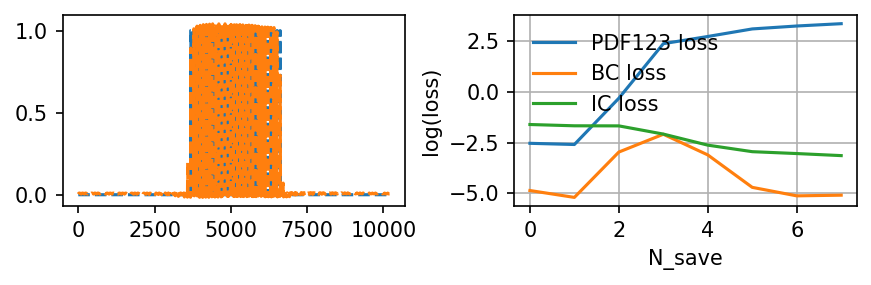

In [7]:
Warmup_ICBC = True
loss = []
# warmup
if Warmup_ICBC is True:
    for i in range(400): # use 10 epoch to warmup IC
        adv_2d_solver.train_IC_warmup()
        if i%50 ==0:
            loss_tmp = adv_2d_solver.current_loss()
            loss.append(loss_tmp)
            print('Warmup_ICBC:',end=' ')
            print_loss(None,loss_tmp)
#Check IC warmup
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(6,2),dpi=150) 

axs[0].plot(adv_2d_solver.IC_expected[:,0].cpu().numpy(),'--')
axs[0].plot(adv_2d_solver.predict(adv_2d_solver.IC_txy)[:,0].cpu().numpy(),'--')
loss_tmp = adv_2d_solver.current_loss()
print_loss(None,loss_tmp)
loss_list = np.array(loss)
N_save = np.arange(loss_list.shape[0])
axs[1].plot(N_save,np.log(loss_list[:,0:3].sum(axis=1))/np.log(10),label='PDF123 loss')
axs[1].plot(N_save,np.log(loss_list[:,3])/np.log(10),label='BC loss')
axs[1].plot(N_save,np.log(loss_list[:,4])/np.log(10),label='IC loss')
axs[1].legend(frameon=False)
plt.ylabel('log(loss)')
plt.xlabel('N_save')
# plt.ylim([-7,1])
plt.grid()
fig.tight_layout()
fig.show()


## Train with PDE, IC and BC

In [8]:
%%time
N_save_num = 20 # how many times of output
N_epoch_batch = 100

N_epoch = N_save_num*N_epoch_batch
IC_iterms = np.zeros((N_save_num,x_axis.size,y_axis.size,3),dtype='float32')
loss = []
#train NN with PDE
for i in range(N_epoch):
    # train and get loss: 
    adv_2d_solver.train(col_poi_batch_size=int(adv_2d_solver.txy_col.shape[0]/20))
    if i%N_epoch_batch == 0:    
        loss_tmp = adv_2d_solver.current_loss()
        loss.append(loss_tmp)
        print_loss(i,loss_tmp)
        # predict and save output of NN_model
        output = adv_2d_solver.predict().reshape((t_axis.size,x_axis.size,y_axis.size,3))
        IC_iterms[int(i/N_epoch_batch),:,:] = output.to('cpu')[0,:,:,:]
        adv_2d_solver.scheduler.step() # decrease LR

Epoch      0 | fn loss1: 6.16e-01 | fn loss2: 5.67e+00 | fn loss3: 5.01e+00 | BC loss: 1.96e-03 | IC loss: 2.99e-02 
Epoch    100 | fn loss1: 1.84e-01 | fn loss2: 4.13e-01 | fn loss3: 5.90e-01 | BC loss: 5.51e-04 | IC loss: 1.57e-02 
Epoch    200 | fn loss1: 7.13e-01 | fn loss2: 4.20e-01 | fn loss3: 6.48e-01 | BC loss: 1.88e-03 | IC loss: 6.96e-03 
Epoch    300 | fn loss1: 4.77e-01 | fn loss2: 4.36e-01 | fn loss3: 4.63e-01 | BC loss: 3.51e-03 | IC loss: 4.45e-03 
Epoch    400 | fn loss1: 3.17e-01 | fn loss2: 4.58e-01 | fn loss3: 3.06e-01 | BC loss: 3.95e-03 | IC loss: 3.42e-03 
Epoch    500 | fn loss1: 3.38e-01 | fn loss2: 2.85e-01 | fn loss3: 1.96e-01 | BC loss: 2.93e-03 | IC loss: 3.56e-03 
Epoch    600 | fn loss1: 3.09e-01 | fn loss2: 5.10e-01 | fn loss3: 4.41e-01 | BC loss: 3.18e-03 | IC loss: 2.65e-03 
Epoch    700 | fn loss1: 5.13e-01 | fn loss2: 5.52e-01 | fn loss3: 5.70e-01 | BC loss: 3.57e-03 | IC loss: 3.47e-03 
Epoch    800 | fn loss1: 2.89e-01 | fn loss2: 3.80e-01 | fn loss

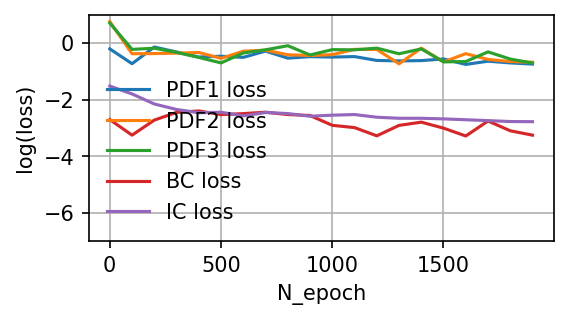

In [9]:
#plot loss
loss_list = np.array(loss)
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(4,2),dpi=150) 
N_epoch = np.arange(loss_list.shape[0])*N_epoch_batch+1
axs.plot(N_epoch,np.log(loss_list[:,0])/np.log(10),label='PDF1 loss')
axs.plot(N_epoch,np.log(loss_list[:,1])/np.log(10),label='PDF2 loss')
axs.plot(N_epoch,np.log(loss_list[:,2])/np.log(10),label='PDF3 loss')
axs.plot(N_epoch,np.log(loss_list[:,3])/np.log(10),label='BC loss')
axs.plot(N_epoch,np.log(loss_list[:,4])/np.log(10),label='IC loss')
axs.legend(frameon=False)
plt.ylabel('log(loss)')
plt.xlabel('N_epoch')
plt.ylim([-7,1])
plt.grid()
fig.show()

# Show Training process for IC

/tmp/ipykernel_135292/1461977105.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


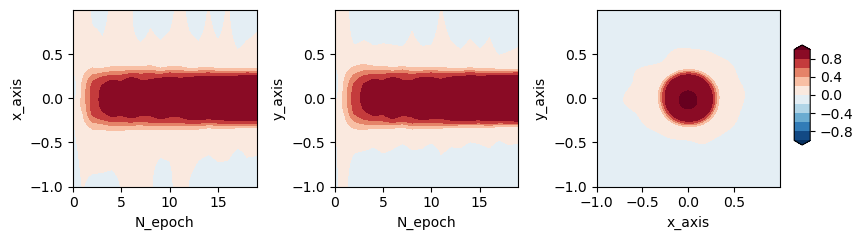

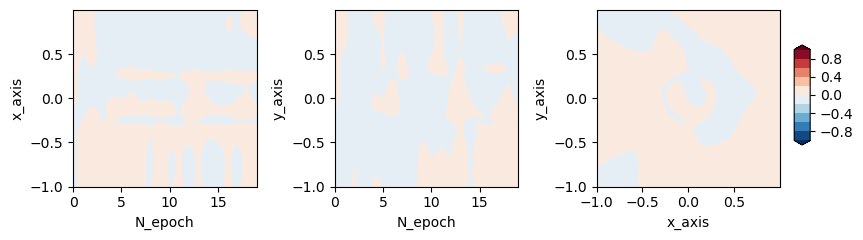

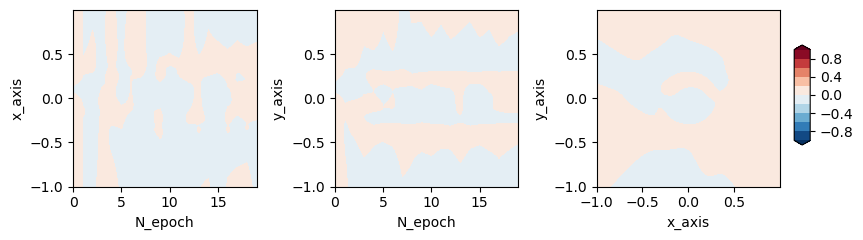

In [10]:
output = adv_2d_solver.predict().reshape((t_axis.size,x_axis.size,y_axis.size,3)).to('cpu')
for i in range(3): # for 3 variables, h, u, v
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(8,2.5),dpi=100) 
    axs = axs.flatten()
    levels = np.arange(-1,1.05,0.2)
    ax = axs[0]
    cb = ax.contourf(np.arange(N_save_num),y_axis,IC_iterms[:,:,int(y_axis.size/2),i].T,
                     levels=levels,extend='both',cmap=plt.cm.RdBu_r)

    ax.set_xlabel('N_epoch')
    ax.set_ylabel('x_axis')
    ax = axs[1]
    ax.contourf(np.arange(N_save_num),x_axis,IC_iterms[:,int(x_axis.size/2),:,i].T,
                     levels=levels,extend='both',cmap=plt.cm.RdBu_r)

    ax.set_xlabel('N_epoch')
    ax.set_ylabel('y_axis')
    ax = axs[2]
    cb = ax.contourf(x_axis,y_axis,output[0,:,:,i].T,
                     levels=levels,extend='both',cmap=plt.cm.RdBu_r)

    ax.set_xlabel('x_axis')
    ax.set_ylabel('y_axis')
    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.999, 0.4, 0.02, 0.4])
    # Draw the colorbar
    cbar = fig.colorbar(cb, cax=cbar_ax,orientation='vertical')
    fig.tight_layout()
    fig.show()

/tmp/ipykernel_135292/2850040223.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


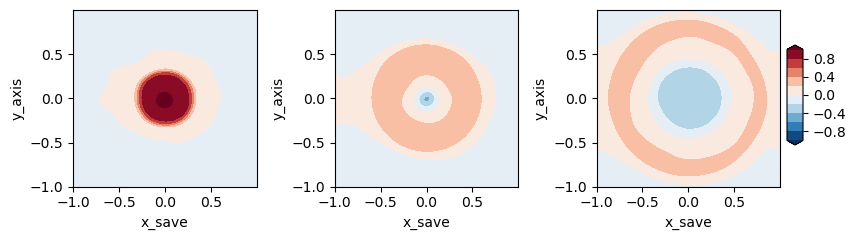

In [11]:
output = adv_2d_solver.predict().reshape((t_axis.size,x_axis.size,y_axis.size,3)).to('cpu')
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(8,2.5),dpi=100) 
axs = axs.flatten()
levels = np.arange(-1,1.05,0.2)
for i in range(3):
    ax = axs[i]
    cb = ax.contourf(x_axis,y_axis,output[i*30+1,:,:,0].T,
                     levels=levels,extend='both',cmap=plt.cm.RdBu_r)

    ax.set_xlabel('x_save')
    ax.set_ylabel('y_axis')
# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.99, 0.4, 0.02, 0.4])
# Draw the colorbar
cbar = fig.colorbar(cb, cax=cbar_ax,orientation='vertical')
fig.tight_layout()
fig.show()

## Energy Conservation

E_p = g|h|h/2

E_k = 0.5H(u^2+v^2)

In [12]:
dx = x_axis[1]-x_axis[0]
dy = y_axis[1]-y_axis[0]
E_p = adv_2d_solver.g.item()*(output[:,:,:,0]*abs(output[:,:,:,0])).sum(axis=[1,2])/2*dx*dy
E_k = 0.5**adv_2d_solver.H.item()*((output[:,:,:,1]**2).sum(axis=[1,2])+(output[:,:,:,2]**2).sum(axis=[1,2]))*dx*dy

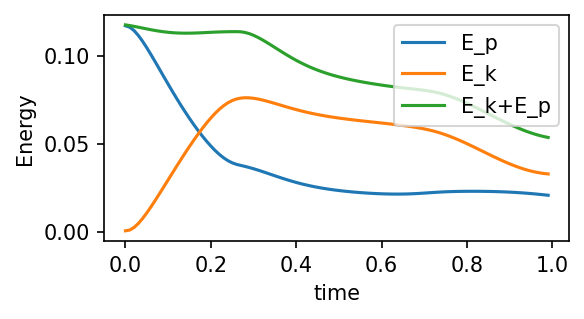

In [13]:
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(4,2),dpi=150) 
plt.plot(t_axis,E_p,label='E_p')
plt.plot(t_axis,E_k,label='E_k')
plt.plot(t_axis,E_k+E_p,label='E_k+E_p')
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend(loc=1)
fig.show()

## Output to different grid (mesh free feature)

In [14]:
# regular grid
t_hr = np.arange(0,t_end,0.025,dtype='float32')    # time
x_hr = np.arange(-1,1+1e-3,2.5e-2,dtype='float32')   # space
y_hr = np.arange(-1,1+1e-3,2.5e-2,dtype='float32')   # space
t_hr_nor,x_hr_nor,y_hr_nor = adv_2d_solver.coordination_normalization(t_hr,x_hr,y_hr)
hr_txy = adv_2d_solver.axis_txy_to_ij(t_hr_nor,x_hr_nor,y_hr_nor)
output_hr = adv_2d_solver.predict(hr_txy).reshape((t_hr.size,x_hr.size,y_hr.size,3)).to('cpu').numpy()

## Plot final results

In [15]:
x_mesh,y_mesh = np.meshgrid(x_hr,y_hr,indexing='ij')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(4,3),dpi=150)
anim,surf = my_anima_3d_h(fig,ax,t_hr,x_mesh,y_mesh,output_hr[:,:,:,0],levels=np.arange(-1,1.01,0.1))
# Add a color bar which maps values to colors.
fig.colorbar(surf, ax=ax, shrink=0.4, aspect=10,pad=0.2)
HTML(anim.to_html5_video())

In [16]:
# import pickle
# data_save = [t_hr,x_hr,y_hr,output_hr]
# pickle.dump(data_save,open('test.p','wb'))